# Data Exploration & Feature Engineering
Read preprocessed data and generate new profile report. Drop number of hours absent since we are only interested in whether or not there has been a significant absence.

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt

df = pd.read_csv('df_preprocessed.csv', index_col=0)
df.drop('Absenteeism_Time_in_Hours', axis=1, inplace=True)
df.profile_report()

## Observations
With the data cleaned, we can examine the correlations among variables. Not surprisingly, injury and sickness have the greatest positive correlation with hours missed in a given day. However, when someone leaves work for a doctorâ€™s appointment, the time lost is very little. 

In addition, the number of children a person has a slightly positive correlation with hours missed.

We also see a strong, positive correlation between Age and BMI, as does the relationship between number of children and pets with transportation expense. The strength of correlation does not seem significant enough to require dropping any variables, but if it does prove necessary, it will be best to drop BMI since age seems to have a stronger correlation with the target variable. In addition, transportation expenses would be dropped since we can get greater insights by considering the number of children and pets. 

Finally, we do see strong, negative correlation between doctor's appointments and sickness/injury. This is likely due to the simple fact that employees are likely to list one or the other as a reason for absence as opposed to both.

## Feature Scaling

In [2]:
from sklearn.preprocessing import StandardScaler

unscaled_predictors = df.drop('Significant_Absence', axis=1)

scaler = StandardScaler()
scaled_predictors = scaler.fit_transform(unscaled_predictors)

# Modeling
We will attempt multiple model types in an effort to predict number of absentee hours in a given day. We will perform an 80/20 train/test split, and use k-fold cross-validation with 5 folds of training data before attempting to predict test results.

## Train / Test Split

In [3]:
from sklearn.model_selection import train_test_split

X = scaled_predictors.copy()
y = df.Significant_Absence

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=123)

## Accuracy Measure
For this analysis, we will use a confusion matrix with the F1 Score as our primary measure of model accuracy. The function below allows for the visualization of the confusion matrix and display of results.

In [4]:
from sklearn.metrics import confusion_matrix, f1_score
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Logistic Regression Gridsearch

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    1.2s finished


Best Logistic Regression Pipeline Score: 0.7451799422601462
Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}

F1 Score (Test Data): 68.70%
Confusion matrix, without normalization


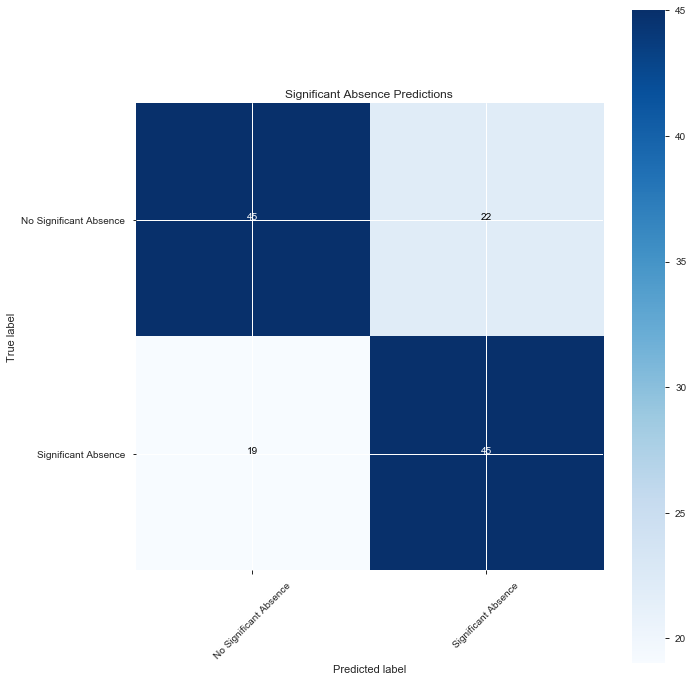

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define accuracy measure
acc_meas = 'f1'

# Create pipeline
logreg_pipe = Pipeline([('logreg', LogisticRegression(random_state=123))])

# Set grid parameters
logreg_grid = [{'logreg__C': [.001, 0.01, 0.1, 1, 10, 100, 1000], 
                'logreg__penalty': ['l1', 'l2']}]

# Implement gridsearch
logreg_gridsearch = GridSearchCV(estimator = logreg_pipe, 
                                 param_grid = logreg_grid, 
                                 scoring = acc_meas, 
                                 cv = 5, verbose = 1, 
                                 return_train_score = True, 
                                 n_jobs=2)

# Fit to data
logreg_gridsearch.fit(X_train, y_train)

# Display results of best model
print(f'Best Logistic Regression Pipeline Score: {logreg_gridsearch.best_score_}')
print(f'Parameters: {logreg_gridsearch.best_params_}')

# Save results to dictionary to compare with other models later
results = {'Pipeline': ['Logistic Regression'], 
           'Top Score': [logreg_gridsearch.best_score_], 
           'Parameters': [logreg_gridsearch.best_params_]}

# Predict test data and display results
y_hat_test = logreg_gridsearch.predict(X_test)
cm = confusion_matrix(y_test, y_hat_test)
score = f1_score(y_test, y_hat_test)
cm_plot_labels = ['No Significant Absence', 'Significant Absence']

print(f'\nF1 Score (Test Data): {score*100:.2f}%')

plot_confusion_matrix(cm, cm_plot_labels, title='Significant Absence Predictions')

### Create Coefficients Dataframe

In [6]:
feature_names = ['Intercept'] + list(unscaled_predictors.columns)

# Get coefficients for best logistic regression model
logreg_coefs = logreg_gridsearch.best_estimator_.named_steps['logreg'].coef_
logreg_interecept = logreg_gridsearch.best_estimator_.named_steps['logreg'].intercept_
coefs = list(logreg_interecept)+list(logreg_coefs[0])

# Create dataframe
coef_df = pd.DataFrame(columns=['Feature Name'], data=feature_names)
coef_df['Logreg Coefs'] = coefs
coef_df

Feature Name  Logreg Coefs
0                 Intercept      0.000000
1    Transportation_Expense      0.486115
2          Distance_to_Work      0.000000
3                       Age      0.000000
4   Daily_Work_Load_Average      0.000000
5           Body_Mass_Index      0.097401
6                 Education     -0.003323
7                  Children      0.336329
8                      Pets     -0.070446
9                  Sickness      0.000000
10                Pregnancy     -0.066848
11                   Injury      0.138337
12             Doctors_Appt     -0.934365
13                  Weekday     -0.002232
14                    Month      0.000000